In [1]:
import numpy as np
#import mlflow
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
from PIL import Image
from dataset import *
from save_load import *
from NN_library.PINN.Block.Block_modular import *
from FEM_2d_elasticity import create_image_3

%load_ext autoreload
%autoreload 2

#mlflow.autolog()

Using device: cuda


In [2]:
def find_deform(K, f):
    u = torch.linalg.solve(K, f)
    u_f = (u * f).sum(dim=(-2, -1))
    return u, u_f

def find_rho(layout, res=8):
    n = torch.where(layout[:,0]!=0, 1, 0).sum(dim=(-2, -1))
    M = (2*res*layout[:,0] + 2*(res-2*layout[:,0])*layout[:,1]) / (res*res)
    rho = M.sum(dim=(-2, -1)) / n
    return rho

def convert(input, layout):
    x = torch.arange(2, 5).to(device=dev)
    output_one_hot = F.gumbel_softmax(input, tau=1, hard=True, eps=1e-10, dim=1)
    output_x_num = (output_one_hot * x.view(1,3,1,1)).sum(dim=1, keepdim=True)
    output_clean = output_x_num * layout[:, [0]].detach()
    return output_clean

## Academic examples

In [3]:
data = dataset_GAN('academic')
args = {'lr' : 0.1, 'epochs' : 100, 'dev' : dev, 'name' : 'NN_library/PINN/Block/Block_3_6x6_k3', 'train_mode' : 'stiffness'}
dis = Block_net(res=5, kernels=[1, 3], train_mode=args['train_mode'], input=1)
dis = load_network(dis, args['name'], args)
dis = dis.to(dev)
for p in dis.parameters():
    p.requires_grad_ = False
dis.eval()

Block_net(
  (conv_blocks): ModuleList(
    (0): Conv_block(
      (c11): Conv2d(1, 16, kernel_size=(1, 1), stride=(1, 1))
      (c12): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
      (c13): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): Conv_block(
      (c11): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (c12): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
      (c13): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (FNN_blocks): ModuleList(
    (0): Block_FNN(
      (convt): ConvTranspose2d(32, 1, kernel_size=(1, 36), stride=(1, 36), bias=False)
    )
    (1): Block_FNN(
      (convt): ConvTranspose2d(64, 1, kernel_size=(1, 528), stride=(1, 528), bias=False)
    )
  )
)

### 5x4 console

In [4]:
batch = 128
layout, support, force, zero_map, DBC, f = data.__getitem__(6)
layout = layout[0].repeat(batch, 1, 1, 1).to(dev)
f = f.to(dev).repeat(batch, 1, 1)
zero_map = zero_map.repeat(batch, 1, 1)
DBC = DBC.repeat(batch, 1, 1).to(dev)

In [5]:
x_0 = torch.zeros(batch, 3, layout.shape[-2], layout.shape[-1]).to(dev)
x_0.requires_grad_()
us = []
outputs = []
loss = []

In [6]:
optimizer = optim.Adam([x_0], lr = 0.2, maximize=False)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=20, threshold=1e-10, verbose=True, eps=1e-10)

In [17]:
for i in range(50):
    y = convert(x_0, layout)
    y[:, :, 3] = y[:, :, 0]
    y[:, :, 2] = y[:, :, 1]
    K = dis(y, zero_map, DBC, f)
    _, u = find_deform(K+DBC, f)
    l = u.sum()
    optimizer.zero_grad()
    l.backward()
    optimizer.step()
    loss.append(l.detach().cpu())
    us.append(u.detach().cpu())
    outputs.append(y.detach().cpu())
    #scheduler.step(l)   

y = convert(x_0, layout)
y[:, :, 3] = y[:, :, 0]
y[:, :, 2] = y[:, :, 1]
K = dis(y, zero_map, DBC, f)
_, u = find_deform(K+DBC, f)
us.append(u.detach().cpu())
outputs.append(y.detach().cpu())

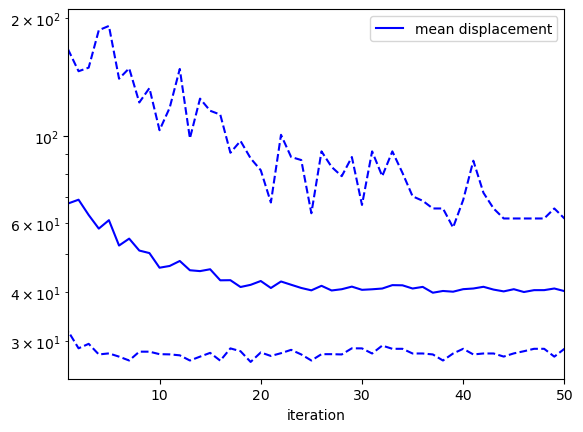

In [18]:
disps = np.array(us)
plt.plot(np.mean(disps, axis=1), 'b')
plt.plot(np.max(disps, axis=1), 'b--')
plt.plot(np.min(disps, axis=1), 'b--')
plt.xlabel('iteration')
plt.xlim([1, 50])
plt.legend(['mean displacement'])
plt.yscale('log')

In [19]:
y_bf = torch.tensor([[[2., 4., 2., 4., 4.],
                     [4., 4., 4., 4., 4.],
                     [4., 4., 4., 4., 4.],
                     [2., 4., 2., 4., 4.], 
                     [0., 0., 0., 0., 0.]]])

K = dis(y_bf.to(dev), zero_map[[0]], DBC[[0]], f[[0]])
_, u_bf = find_deform(K+DBC[[0]], f[[0]])

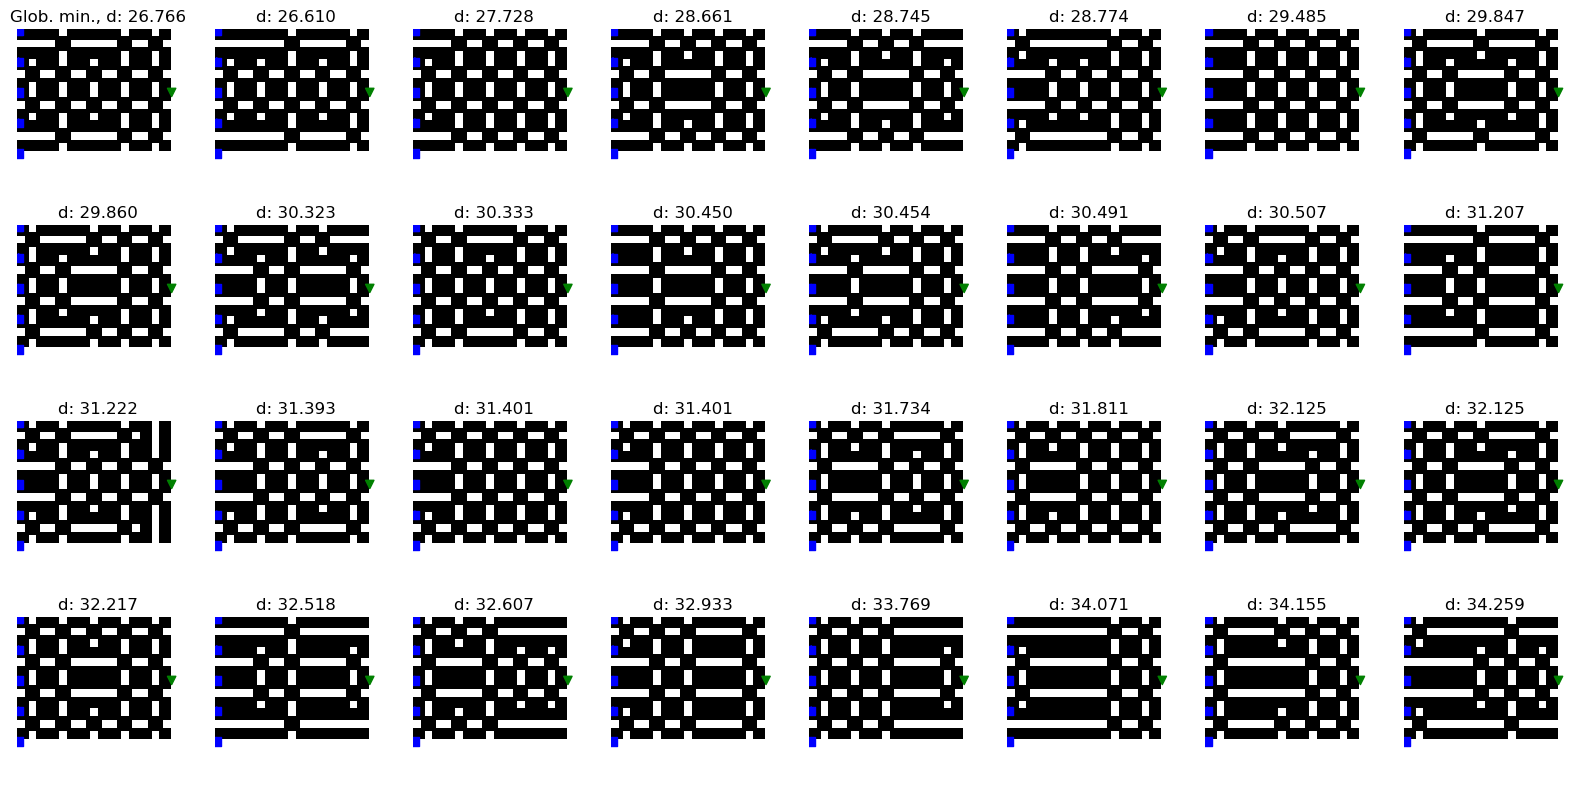

In [20]:
batch = 32
x_g, y_g = np.meshgrid(np.linspace(0, layout.shape[-2]*8, layout.shape[-2]+1), np.linspace(0, layout.shape[-1]*8, layout.shape[-1]+1))
fig, axs = plt.subplots(batch//8, 8, figsize=(2*8, 2*batch//8))
best_idx = torch.argsort(us[-1])
for j in range(batch-1):
    i = best_idx[j].item()
    img = create_image_3(outputs[-1][i])
    axs.flat[j+1].imshow(img, cmap='Greys_r')
    axs.flat[j+1].scatter(x_g, y_g, c='b', marker='s', alpha=support[0].detach().cpu())
    axs.flat[j+1].scatter(x_g, y_g, c='b', marker='^', alpha=support[1].detach().cpu())
    axs.flat[j+1].scatter(x_g, y_g, c='g', marker='>', alpha=force[0].detach().cpu())
    axs.flat[j+1].scatter(x_g, y_g, c='g', marker='v', alpha=force[1].detach().cpu())
    axs.flat[j+1].set_title(f'd: {us[-1][i]:.3f}')
    axs.flat[j+1].axis('off')
axs.flat[0].imshow(create_image_3(torch.cat([y_bf, y_bf])), cmap='Greys_r')
axs.flat[0].scatter(x_g, y_g, c='b', marker='s', alpha=support[0].detach().cpu())
axs.flat[0].scatter(x_g, y_g, c='b', marker='^', alpha=support[1].detach().cpu())
axs.flat[0].scatter(x_g, y_g, c='g', marker='>', alpha=force[0].detach().cpu())
axs.flat[0].scatter(x_g, y_g, c='g', marker='v', alpha=force[1].detach().cpu())
axs.flat[0].set_title(f'Glob. min., d: {u_bf.item():.3f}')
axs.flat[0].axis('off')
plt.tight_layout()

### Run FEM

In [11]:
from FEM_2d_elasticity import *

coarse_grid = (5, 5)
res = 8
coarse_x, coarse_y = np.meshgrid(np.arange(coarse_grid[0]+1), np.arange(coarse_grid[1]+1))
coarse_coordinates = np.vstack([coarse_x.flatten(), coarse_y.flatten()]).T
x, y = np.meshgrid(np.linspace(0, coarse_grid[0], coarse_grid[0]*res+1), np.linspace(0, coarse_grid[1], coarse_grid[1]*res+1))
x = x.flatten()
y = y.flatten()
glob_numbering = np.reshape(np.arange(len(x)), (coarse_grid[0]*res+1, coarse_grid[1]*res+1))
coarse_idx = glob_numbering[0::res,0::res].flatten()


# Create module stiffness matrices
K_module = {}
for i in range(1, 5):   
    K_module[(i, i)] = create_module_domain_from_png(1, 1e-2, 0.3, f'modules_3/{i}.png')
K_module[(0, 0)] = np.zeros_like(K_module[(1, 1)])

In [12]:
y_bf = torch.cat([y_bf, y_bf], dim=0)

In [13]:
support_coarse = list(range(0, 2*(coarse_grid[0]-1)*(coarse_grid[1]+1)+1, 2*(coarse_grid[1]+1))) + list(range(1, 2*(coarse_grid[0]-1)*(coarse_grid[1]+1)+2, 2*(coarse_grid[1]+1))) 
support_hd = 2 * coarse_idx[np.array(support_coarse) // 2] + (np.array(support_coarse) % 2)
force_idx = np.vstack([2*coarse_idx, 2*coarse_idx+1]).T.flatten()
coarse_with_BC_idx = np.setdiff1d(force_idx, support_hd, assume_unique=False)
row_mask = np.isin(force_idx, coarse_with_BC_idx)
mask = np.outer(row_mask, row_mask)
F_glob = np.zeros((2*len(x), 1))
F_glob[force_idx] = f[0].detach().cpu()
f_idx = np.argwhere(f[0].detach().cpu().numpy())[0,0]
K_glob = assemble_global_stiffness(K_module, y_bf.detach().cpu().numpy().reshape(2, -1).T, coarse_grid, len(x), res)

K_ff, F_f, dof = apply_BCs(K_glob, F_glob, support_hd)
U_ff = np.linalg.solve(K_ff.astype(np.float32), F_f.astype(np.float32))
U_glob = np.zeros((2*len(x), 1))
U_glob[dof] = U_ff
U_glob[force_idx][f_idx]

array([25.23810005])

In [14]:
u_real = []
for n in range(128):
    K_glob = assemble_global_stiffness(K_module, torch.cat([outputs[-1][n], outputs[-1][n]], dim=0).detach().cpu().numpy().reshape(2, -1).T, 
                                       coarse_grid, len(x), res)
    K_ff, F_f, dof = apply_BCs(K_glob, F_glob, support_hd)
    U_ff = np.linalg.solve(K_ff.astype(np.float32), F_f.astype(np.float32))
    U_glob = np.zeros((2*len(x), 1))
    U_glob[dof] = U_ff
    u_real.append(U_glob[force_idx][f_idx])

Text(0, 0.5, 'displacement')

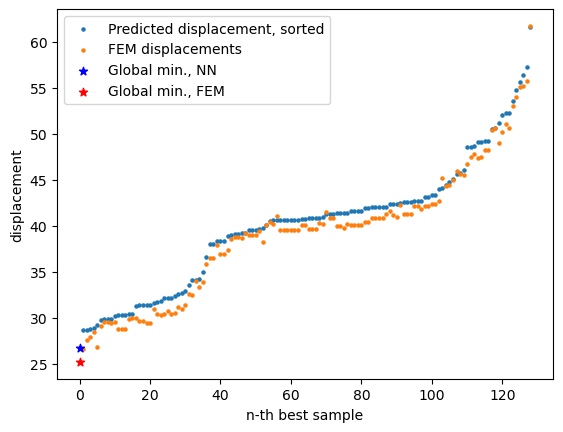

In [16]:
sorted = np.argsort(np.array(us[-1]))
plt.scatter(1+np.arange(128), us[-1][sorted], s=5)
plt.scatter(1+np.arange(128), np.array(u_real)[sorted], s=5)
plt.scatter(0, 26.766, marker='*', c='b')
plt.scatter(0, 25.2381, marker='*', c='r')
plt.legend(['Predicted displacement, sorted', 'FEM displacements', 'Global min., NN', 'Global min., FEM'])
plt.xlabel('n-th best sample')
plt.ylabel('displacement')

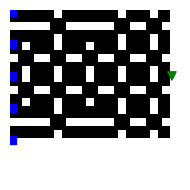

In [98]:
plt.figure(figsize=[2, 2])
img = create_image_3(y_bf)
plt.imshow(img, cmap='Greys_r')
plt.scatter(x_g, y_g, c='b', marker='s', alpha=support[0].detach().cpu())
plt.scatter(x_g, y_g, c='b', marker='^', alpha=support[1].detach().cpu())
plt.scatter(x_g, y_g, c='g', marker='>', alpha=force[0].detach().cpu())
plt.scatter(x_g, y_g, c='g', marker='v', alpha=force[1].detach().cpu())
plt.axis('off')
plt.tight_layout()

In [ ]:
from itertools import product

# Define the range of integers to be used in the matrix
range_of_values = [2, 3, 4]

# Generate all possible combinations for a 2x5 matrix
all_combinations = product(range_of_values, repeat=10)

# Loop through each combination to print the 2x5 matrices

u_min = np.inf
layout_min = None
for combination in all_combinations:
    matrix = [combination[:5], combination[5:]]  # Split the combination into two rows
    layout = np.zeros((2, 5, 5))
    layout[:, :2] = matrix
    layout[:, [3,2]] = matrix
    K_glob = assemble_global_stiffness(K_module, layout.reshape(2, -1).T,coarse_grid, len(x), res)
    K_ff, F_f, dof = apply_BCs(K_glob, F_glob, support_hd)
    U_ff = np.linalg.solve(K_ff.astype(np.float32), F_f.astype(np.float32))
    U_glob = np.zeros((2*len(x), 1))
    U_glob[dof] = U_ff
    u = U_glob[force_idx][f_idx]
    if u < u_min:
        u_min = u
        layout_min = layout
        print(u_min)
    

In [13]:
print(layout_min)

[[[2. 4. 2. 4. 4.]
  [4. 4. 4. 4. 4.]
  [4. 4. 4. 4. 4.]
  [2. 4. 2. 4. 4.]
  [0. 0. 0. 0. 0.]]

 [[2. 4. 2. 4. 4.]
  [4. 4. 4. 4. 4.]
  [4. 4. 4. 4. 4.]
  [2. 4. 2. 4. 4.]
  [0. 0. 0. 0. 0.]]]
